<a href="https://colab.research.google.com/github/aml7hawaiiedu/CCAPLandCoverProject/blob/main/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
install.packages('gdalutils')
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘gdalutils’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘Rcpp’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this packag

# New Section

In [4]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI)
library(zip)

Linking to GEOS 3.10.2, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.


Attaching package: ‘zip’


The following objects are masked from ‘package:utils’:

    unzip, zip




In [5]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=3b486788e9425cddbd7d2e050d786198&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYa1dTX1VqUFRwczVoY3YxZjBoSFk5bW9zSk4wb0g2a2xMd2tZcFRHWGlCbWFfY1VidEpFNENJV0xyVnB6RE1XdyIsInN0YXRlIjoiM2I0ODY3ODhlOTQyNWNkZGJkN2QyZTA1MGQ3ODYxOTgifQ==


In [6]:
# Hawaii
# Kahoolawe
# Kauai
# Lanai
# Maui - running on 9/13/23
# Molokai - ran on 9/12/23 - complete
# Niihau - running on 9/13/23 - complete
# Oahu

In [31]:
print('hello world')

[1] "hello world"


In [33]:
dir.create('/content/Hawaii_2005_009/') # 2010_Hawaii_CCAP # 2010_Hawaii_LS
# dir.create('/content/Hawaii05_LR/') # 2010_Hawaii_CCAP # 2010_Hawaii_LS
# dir.create('/content/Hawaii05_TL/') # 2010_Hawaii_CCAP # 2010_Hawaii_LS
# dir.create('/content/Hawaii05_TR/') # 2010_Hawaii_CCAP # 2010_Hawaii_LS

# dir.create('/content/Kauai10/') # 2010_Kauai_CCAP # 2010_Kauai_LS

# dir.create('/content/Lanai11/') # 2011_Lanai_CCAP # 2011_Lanai_LS

# dir.create('/content/Maui10/') # 2010_Maui_CCAP # 2010_Maui_LS

# dir.create('/content/Molokai10/') # 2010_Molokai_CCAP # 2010_Molokai_LS

# dir.create('/content/Niihau10/') # 2010_Niihau_CCAP # 2010_Niihau_LS

# dir.create('/content/Oahu11/') # 2011_Oahu_CCAP # 2011_Oahu_LS


Warning message in dir.create("/content/Hawaii_2005_009/"):
“'/content/Hawaii_2005_009' already exists”


In [34]:
# Hawaii
# CCAP:  https://drive.google.com/file/d/1SbGlSt9e8iqDQrXGjrMQrm7PF9BJhmYl/view?usp=drive_link
drive_download(file = as_id('1SbGlSt9e8iqDQrXGjrMQrm7PF9BJhmYl'), path =  '/content/Hawaii_2005_009/ccap_Hawaii_2005_009.tif', overwrite = FALSE)
# LS:  https://drive.google.com/file/d/13SayNyz3IqRt_eDTeAv-4HY0Oohyf3E2/view?usp=drive_link
drive_download(file = as_id('13SayNyz3IqRt_eDTeAv-4HY0Oohyf3E2'), path =  '/content/Hawaii_2005_009/ls_Hawaii_2005_009.tif', overwrite = TRUE)


File downloaded:

• ccap_2005_009.tif <id: 1SbGlSt9e8iqDQrXGjrMQrm7PF9BJhmYl>

Saved locally as:

• /content/Hawaii_2005_009/ccap_Hawaii_2005_009.tif

File downloaded:

• LandSat_2005_009.tif <id: 13SayNyz3IqRt_eDTeAv-4HY0Oohyf3E2>

Saved locally as:

• /content/Hawaii_2005_009/ls_Hawaii_2005_009.tif



In [35]:
ccap_raster <- stack('/content/Hawaii_2005_009/ccap_Hawaii_2005_009.tif')
ls_raster <- stack('/content/Hawaii_2005_009/ls_Hawaii_2005_009.tif')

In [36]:
ls_raster_extended <- extend(ls_raster, projectExtent(ccap_raster, ls_raster), value=NA)

In [37]:
ccap_raster
ls_raster

class      : RasterStack 
dimensions : 20982, 18302, 384012564, 1  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 266695.1, 310619.9, 2092889, 2143246  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=5 +datum=WGS84 +units=m +no_defs 
names      : Layer_1 


class      : RasterStack 
dimensions : 1709, 1491, 2548119, 7  (nrow, ncol, ncell, nlayers)
resolution : 29.46655, 29.46594  (x, y)
extent     : 266687.3, 310622, 2092887, 2143244  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=5 +datum=WGS84 +units=m +no_defs 
names      : ls_Hawaii_2005_009_1, ls_Hawaii_2005_009_2, ls_Hawaii_2005_009_3, ls_Hawaii_2005_009_4, ls_Hawaii_2005_009_5, ls_Hawaii_2005_009_6, ls_Hawaii_2005_009_7 


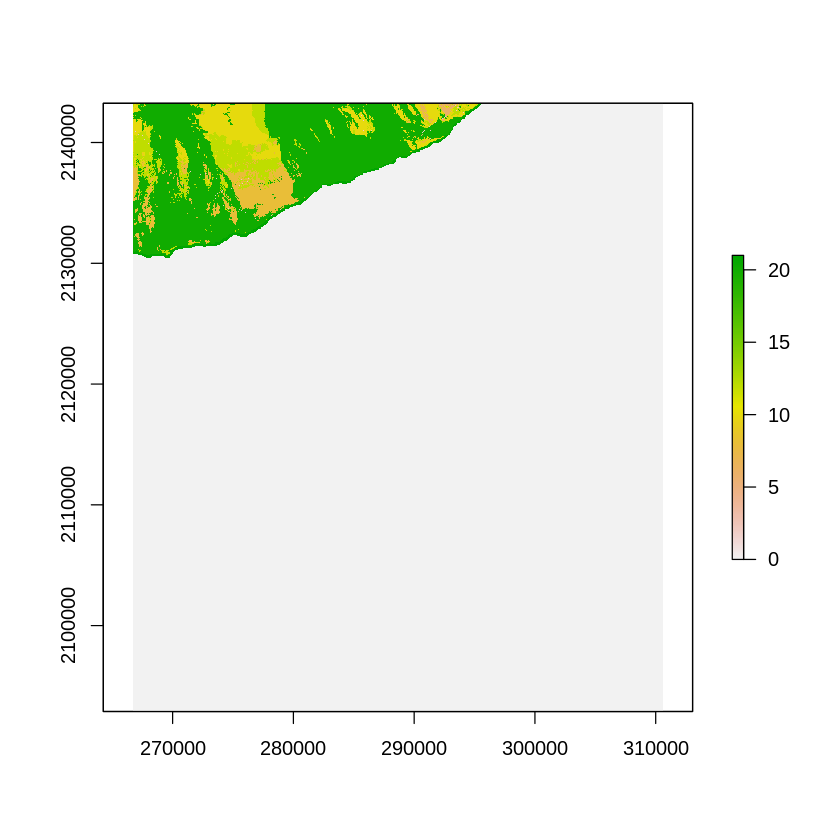

In [38]:
ccap_raster %>% plot

In [39]:
ncol(ccap_raster)

nrow(ccap_raster)


y_end <- c(seq(1,ccap_raster %>% nrow,512),nrow(ccap_raster))[-1]
x_end <- c(seq(1,ccap_raster %>% ncol,512),ncol(ccap_raster))[-1]

extract_grid <- expand.grid(x_end,y_end) %>% data.table

names(extract_grid) <- c('x_end','y_end')

extract_grid$x_org <- extract_grid$x_end - 512
extract_grid$y_org <- extract_grid$y_end - 512

extract_grid$id <- 1:nrow(extract_grid)

[1] 18302

[1] 20982

In [40]:
# dir.create('/TrainingData/Niihau')
# Specify the path for the new folder/directory
new_folder_path <- "/content/Hawaii_2005_009/Images"
new_folder_path2 <- "/content/Hawaii_2005_009/Labels"
# Use dir.create to create the new folder
dir.create(new_folder_path, showWarnings = FALSE)

# Check if the folder was created successfully
if (file.exists(new_folder_path)) {
  cat("Folder created:", new_folder_path, "\n")
} else {
  cat("Failed to create folder:", new_folder_path, "\n")
}


# Use dir.create to create the new folder
dir.create(new_folder_path2, showWarnings = FALSE)
# Check if the folder was created successfully
if (file.exists(new_folder_path2)) {
  cat("Folder created:", new_folder_path2, "\n")
} else {
  cat("Failed to create folder:", new_folder_path2, "\n")
}

Folder created: /content/Hawaii_2005_009/Images 
Folder created: /content/Hawaii_2005_009/Labels 


In [41]:
result_dt <-
1:nrow(extract_grid) %>% lapply(function(x){

  nrow <- 0
  ncol <- 0
  i <- 0
  while(nrow !=512 | ncol != 512){
    i <- i + 1
    # Calculate the geographic coordinates for the cropping extent
    xmin <- xFromCol(ccap_raster, extract_grid[x,]$x_org) + rnorm(1)*.01*2.4
    xmax <- xFromCol(ccap_raster, extract_grid[x,]$x_end) + rnorm(1)*.01*2.4
    ymin <- yFromRow(ccap_raster, extract_grid[x,]$y_end) + rnorm(1)*.01*2.4 # Note row_max as raster origin is top-left
    ymax <- yFromRow(ccap_raster, extract_grid[x,]$y_org) + rnorm(1)*.01*2.4 # Note row_min as raster origin is top-left

    e <- extent(xmin, xmax, ymin, ymax)

    ccap_cropped_raster <- crop(ccap_raster, e)

    nrow <- nrow(ccap_cropped_raster)
    ncol <- ncol(ccap_cropped_raster)


    # print(dim(ccap_cropped_raster))
    if(i>1000){return('failed to converge')}
    }

  ls_cropped_raster <- crop(ls_raster_extended, projectExtent(ccap_cropped_raster,ls_raster))

  ls_resampled_raster <- projectRaster(ls_cropped_raster,ccap_cropped_raster)
  print(ls_resampled_raster)
  pixel_table <- (table(values(ccap_cropped_raster))/ncell(ccap_cropped_raster)) %>% data.table

  names(pixel_table) <- c('label','percent')

  out_dt <- data.table(extract_grid[x,],xmin = xmin,xmax =xmax,ymin= ymin,ymax, pixel_table)

  if(ls_resampled_raster %>% nrow ==512 & ls_resampled_raster %>% ncol ==512 & ccap_cropped_raster%>% nrow ==512 & ccap_cropped_raster%>% ncol ==512){
    ls_resampled_raster %>%
    writeRaster(., paste("/content/Hawaii_2005_009/Images/",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)

    ccap_cropped_raster %>%
    writeRaster(., paste("/content/Hawaii_2005_009/Labels/",extract_grid[x,]$x_org,'_',extract_grid[x,]$y_org,'.tif',sep=''),overwrite=T)
  }else(print('uh oh'))

  return(out_dt)
})
result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite("/content/Hawaii_2005_009/Hawaii_2005_009.csv") # /content/Maui10/

result_dt[ result_dt %>% lapply(function(x){is.data.table(x)}) %>% unlist] %>% rbindlist %>%
fwrite("/content/Hawaii_2005_009.csv") # make a copy outside of the zip folder too

class      : RasterBrick 
dimensions : 512, 512, 262144, 7  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 266697.5, 267926.3, 2142015, 2143243  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=5 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : ls_Hawaii_2005_009_1, ls_Hawaii_2005_009_2, ls_Hawaii_2005_009_3, ls_Hawaii_2005_009_4, ls_Hawaii_2005_009_5, ls_Hawaii_2005_009_6, ls_Hawaii_2005_009_7 
min values :             176.3085,             276.6992,             218.0649,             788.8517,             600.7700,             351.2905,              66.0000 
max values :            473.85858,            677.45948,            676.46345,           2495.31004,           1793.45689,           1120.78651,             68.80518 

class      : RasterBrick 
dimensions : 512, 512, 262144, 7  (nrow, ncol, ncell, nlayers)
resolution : 2.4, 2.4  (x, y)
extent     : 267923.9, 269152.7, 2142017, 2143246  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +z

In [42]:
zip(zipfile = "/content/Hawaii_2005_009.zip",
    files = c("/content/Hawaii_2005_009/Images",
              "/content/Hawaii_2005_009/Labels",
              "/content/Hawaii_2005_009/Hawaii_2005_009.csv"))

Warning message in fix_absolute_paths(data$key):
“Dropping leading `/` from paths, all paths in a zip file must be relative paths.”


In [43]:
# revised_trainingdata https://drive.google.com/drive/folders/1F6MldV4UI0z7zzoa9GNgzy5KHu2j0G9d?usp=drive_link
drive_upload(media = "/content/Hawaii_2005_009.zip", path = as_id("1F6MldV4UI0z7zzoa9GNgzy5KHu2j0G9d"))

Auto-refreshing stale OAuth token.

Local file:

• /content/Hawaii_2005_009.zip

Uploaded into Drive file:

• Hawaii_2005_009.zip <id: 1zJx0mQZjLwBXmQJHiL9MMa8IT-wKf85B>

With MIME type:

• application/zip

